<H3>First Get the Distributions for the Input Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
input_props = pd.read_csv('data\\test_physicochem_props.csv')
input_props.head(5)

,aliphatic_index,boman,charge_ph3,charge_ph7,charge_ph11,hydrophobic_moment,hydrophobicity,instability_index,isoelectric_point,molecular_weight
0,110.833333,1.186667,0.044464,-0.112690,-0.191966,0.011013,0.191667,59.300000,3.844114,4038.61814
1,122.307692,0.029744,0.131391,0.052730,-0.068106,0.011201,0.720513,55.551282,8.803813,4229.10364
2,39.000000,-0.819000,0.117850,0.002607,-0.284665,0.004400,0.220000,58.800000,7.355498,1367.66394
3,71.153846,-0.283077,0.076752,-0.003726,-0.180603,0.015219,0.388462,53.880769,7.179598,2964.52844
4,125.555556,1.011333,0.193382,0.010110,-0.107462,0.008725,-0.060000,51.288889,7.918720,5310.22294


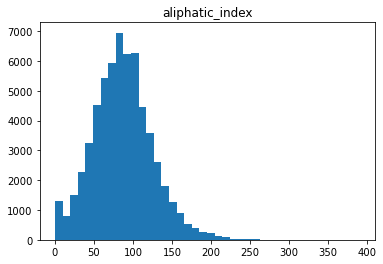

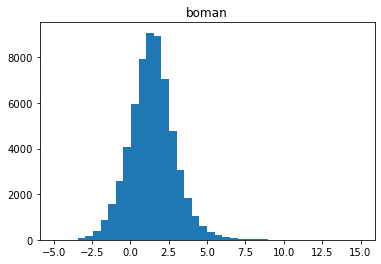

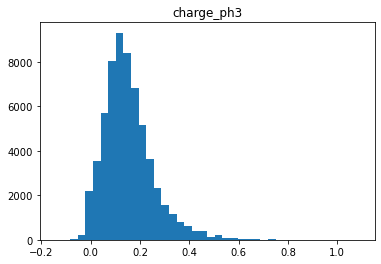

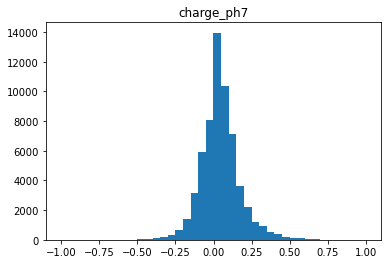

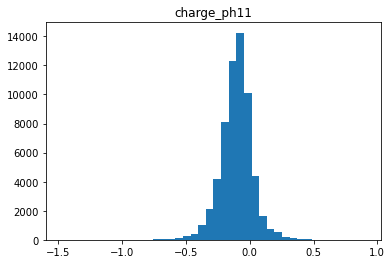

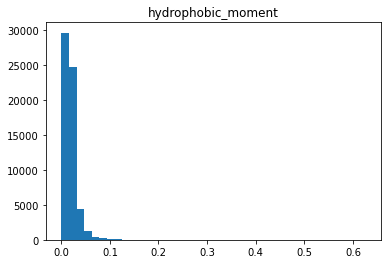

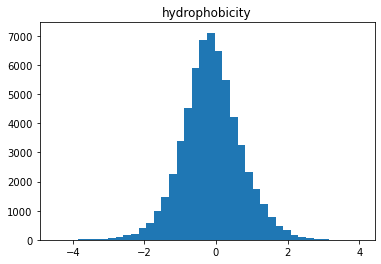

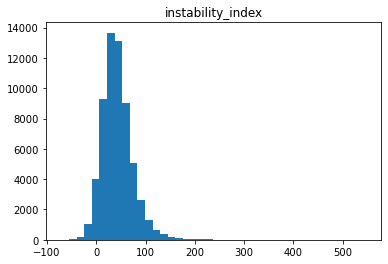

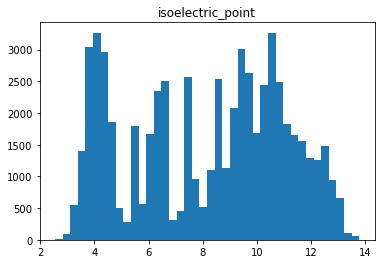

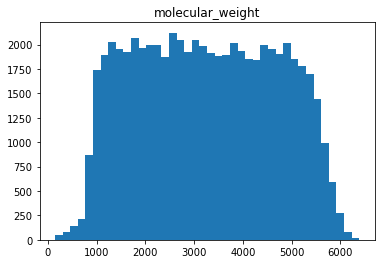

In [3]:
for col in input_props.columns:
    plt.figure()
    plt.hist(input_props[col],bins=40)
    plt.title('{}'.format(col))

<H3> Now get samples from the model and chech their distributions

In [2]:
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
import glob
import re
import os
import random

gpu = True

num_sequences = 500_000
batch_size = 500#setting for reconstruction
example_data = 'data\\peptide_test.txt'
save_dir_loc = 'model_analyses\\sample\\' #folder in which to save outpts
save_dir_name = 'test' #appended to identify data: train|test|other|etc...

ckpt_list = glob.glob(""+"checkpointz\\to_slurm//**//*.ckpt", recursive = True) #grab all checkpoint
print('current working directory: ',os.getcwd())

for i in range(len(ckpt_list)):
    #search the current directory for the model name and load that model
    model_dic = {'trans':'TransVAE','aae':'AAE','rnnattn':'RNNAttn','rnn':'RNN','wae':'WAE'}
    model_src = ckpt_list[i]
    print('working on: ',model_src,'\n')
    model_name = list(filter(None,[key for key in model_dic.keys() if key in model_src.split('\\')[-1]]))
    model = locals()[model_dic[model_name[0]]](load_fn=model_src) #use locals to call model specific constructor
    
    #create save directory for the current model according to latent space size
    latent_size = re.findall('(latent[\d]{2,3})', model_src)
    save_dir= save_dir_loc+model.name+"_"+latent_size[0]+"_"+save_dir_name
    if not os.path.exists(save_dir):os.mkdir(save_dir) 
    save_dir= save_dir+"//" 
    save_df = pd.DataFrame() #this will hold the number variables and save to CSV
    
    #load the true labels
    data = pd.read_csv(example_data).to_numpy() 
    data_1D = data[:num_sequences,0] #gets rid of extra dimension
    #true_props_data = pd.read_csv(true_prop_src).to_numpy()
    #true_props = true_props_data[0:num_sequences,0]

#     print("data loaded")
#     #get the log.txt file from the ckpt and model name then plot loss curves
#     loss_src = '_'.join( ("log",model_src.split('\\')[-1].split('_')[1],model_src.split('\\')[-1].split('_')[2][:-4]+"txt") )
#     src= '\\'.join([str(i) for i in model_src.split('\\')[:-1]])+"\\"+loss_src
#     print(loss_src, src)
#     loss_plots(src)
    
     ##moving into memory and entropy
    if model.model_type =='aae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) #50_000
    elif model.model_type == 'wae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) 
    else:
        mems, mus, logvars = model.calc_mems(data[:65_000], log=False, save=False) #subset size 1200*35=42000 would be ok
    
    
    
# #     Section dealing with sequence generation metrics and bootstrapping from the latent space
#     #first randomly sample points within the latents space
#     rnd_seq_count =30_000
#     rnd_latent_list=[] #generate N latent space vectors
#     mem_min = np.min(mus)
#     mem_max = np.max(mus)
#     for seq in range(rnd_seq_count):
#         rnd_latent_list.append( np.array([random.uniform(mem_min,mem_max) for i in range(model.params['d_latent'])]).astype(np.float32) )
    
#     model.params['BATCH_SIZE'] = 300
#     rnd_token_list=np.empty((rnd_seq_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125
    
#     #decode these points into predicted amino acid tokens (integers)
#     for batch in range(0,rnd_seq_count,model.params['BATCH_SIZE']):
#         rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(rnd_latent_list[batch:batch+model.params['BATCH_SIZE']]).cuda()).cpu()
    
#     #turn the tokens into characters
#     decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])
#     decoded_rnd_seqs[:]=[x for x in decoded_rnd_seqs if x] #removes the empty lists
    

current working directory:  c:\Users\sam\Documents\GitHub\latent-spaces-amps
working on:  checkpointz\to_slurm\trans_latent128\300_trans1x-128_peptide.ckpt 



In [21]:
# Section dealing with sequence generation metrics and bootstrapping from the latent space
#first randomly sample points within the latents space
rnd_seq_count =5_000
rnd_latent_list=[] #generate N latent space vectors
mem_mean = np.mean(mus)

for seq in range(rnd_seq_count):
    rnd_latent_list.append( np.array([np.random.normal(mem_mean,1) for i in range(model.params['d_latent'])]).astype(np.float32) )

model.params['BATCH_SIZE'] = 250
rnd_token_list=np.empty((rnd_seq_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125

#decode these points into predicted amino acid tokens (integers)
for batch in range(0,rnd_seq_count,model.params['BATCH_SIZE']):
    rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(rnd_latent_list[batch:batch+model.params['BATCH_SIZE']]).cuda()).cpu()

#turn the tokens into characters
decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])
decoded_rnd_seqs[:]=[x for x in decoded_rnd_seqs if x] #removes the empty lists

decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 cu

In [22]:
decoded_rnd_seqs_big=[x for x in decoded_rnd_seqs if len(x)>2] #removes the empty lists


In [23]:
decoded_rnd_seq = decoded_rnd_seqs_big

In [24]:
import peptides
dict_list=[]

for seq in decoded_rnd_seqs:
    pep = peptides.Peptide(seq)
    dict_list.append(
        {"aliphatic_index":pep.aliphatic_index(),
     "boman":pep.boman(),
     "charge_ph3":pep.charge(pH=3)/len(seq[0]),
     "charge_ph7":pep.charge(pH=7)/len(seq[0]),
     "charge_ph11":pep.charge(pH=11)/len(seq[0]),
    "hydrophobicity":pep.hydrophobicity(),
    "instability_index":pep.instability_index(),
    "isoelectric_point":pep.isoelectric_point(),
    "molecular_weight":pep.molecular_weight()} )


In [25]:
df = pd.DataFrame(dict_list)
df.to_csv('data/sampled_physicochem_props.csv',index=False)

In [26]:
sampled_props = pd.read_csv('data\\sampled_physicochem_props.csv')
sampled_props.head(5)

,aliphatic_index,boman,charge_ph3,charge_ph7,charge_ph11,hydrophobicity,instability_index,isoelectric_point,molecular_weight
0,0.000000,2.393333,1.179505,0.997689,-0.700222,-1.666667,-21.633333,9.700003,304.34634
1,45.918367,1.772653,6.521257,-0.786678,-3.794835,-0.971429,70.781633,6.784602,5419.11704
2,109.200000,0.790400,6.706176,2.030467,-2.288681,0.356000,37.130000,9.577737,5732.84954
3,127.916667,0.217917,9.943343,7.997280,0.827283,0.608333,-10.208333,11.476463,5485.84074
4,117.000000,0.911000,2.179504,1.996836,-0.627136,0.020000,-24.010000,10.454925,1121.34504


In [9]:
#input_props.shape, sampled_props.shape

In [26]:
# for col in input_props.columns:
#     print(max(input_props[col]), min(input_props[col]))

390.0 0.0
14.92 -4.92
1.089252779 -0.144954947
0.999870707 -1.000561366
0.908366413 -1.476654428
0.6262558000000001 4.01e-05
4.0 -4.5
546.375 -71.04722222
13.77875663 2.544293305
6387.48534 146.14594


In [19]:
for seq in data_1D:
    pep = peptides.Peptide(seq)
    dict_list.append(
        {"aliphatic_index":pep.aliphatic_index(),
     "boman":pep.boman(),
     "charge_ph3":pep.charge(pH=3)/len(seq[0]),
     "charge_ph7":pep.charge(pH=7)/len(seq[0]),
     "charge_ph11":pep.charge(pH=11)/len(seq[0]),
    "hydrophobicity":pep.hydrophobicity(),
    "instability_index":pep.instability_index(),
    "isoelectric_point":pep.isoelectric_point(),
    "molecular_weight":pep.molecular_weight()} )
df = pd.DataFrame(dict_list)
df.to_csv('data/new_test_physicochem_props.csv',index=False)
input_props = pd.read_csv('data\\new_test_physicochem_props.csv')


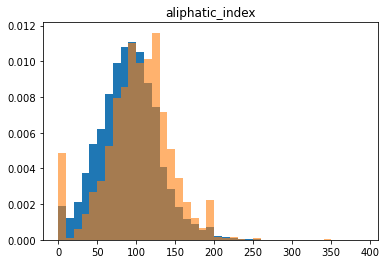

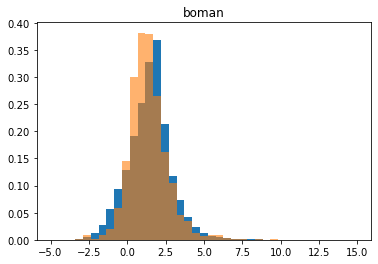

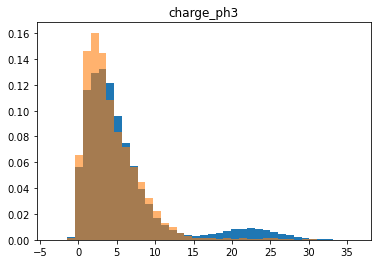

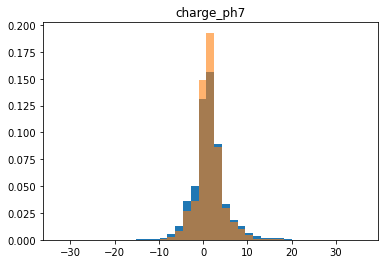

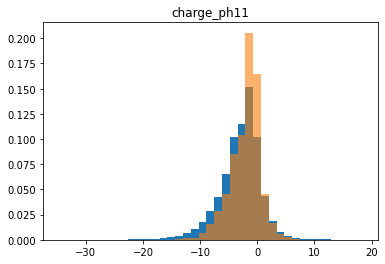

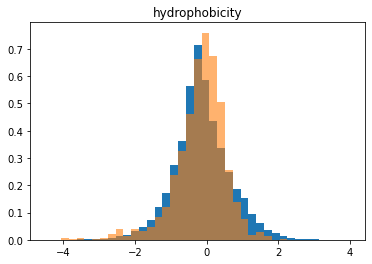

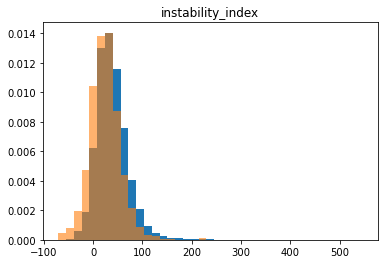

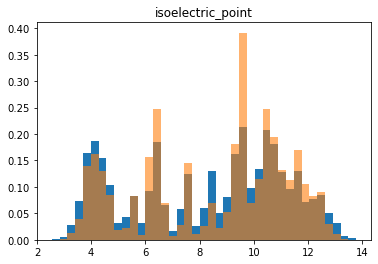

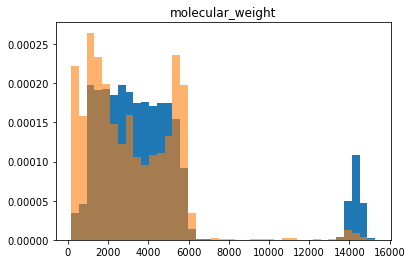

In [27]:
for col in input_props.columns:
    if col=='hydrophobic_moment':
        continue
    plt.figure()
    bins = np.linspace(min(input_props[col]), max(input_props[col]), 40)
    plt.hist(input_props[col],bins=bins, density=True)
    plt.hist(sampled_props[col],bins=bins, density=True, alpha=0.6)
    plt.title('{}'.format(col))
    plt.savefig('distributions\\transformer_128_model_{}_distribution.png'.format(col),facecolor='white',transparent=None, dpi=600)
    

In [12]:
torch.cuda.empty_cache() #free allocated CUDA memory